# Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from timeit import default_timer as timer
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from collections import Counter
import os
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models, transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split, StratifiedKFold
from torchinfo import summary
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import pandas as pd
from tempfile import TemporaryDirectory

print(torch.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.0.0


In [2]:
# Consider aesthetics 
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 12})

In [3]:
import engine
import helper_functions

# 1. **Loading the Dataset**

As mentioned in the [Data Exploration](https://www.kaggle.com/code/kyriakospsallidas/exploratory-analysis) stage of the project, there is an imbalance in class distribution between the test and validation splits, while the training split is balanced. To address this issue, we merge all the images from the train, test, and validation sub-folders into a unified directory called `fungi-all`.

In [4]:
all_directory = '/kaggle/input/fungi-all'
DATA_DIR = all_directory
dataset = ImageFolder(DATA_DIR)
labels = dataset.targets
img_per_class = dict(Counter(dataset.targets))

print(dataset)
print(dataset.class_to_idx)

Dataset ImageFolder
    Number of datapoints: 6801
    Root location: /kaggle/input/fungi-all
{'H1': 0, 'H2': 1, 'H3': 2, 'H5': 3, 'H6': 4}


---

## 2. **Loading the Vision Transformer Base 16 pretrained vision transformer**

In this notebook we will utilzie the Vision Transformer Base 16 Model, as described in the famous paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929). 
Compared to the golden standard for image classification tasks which are CNNs, transformers offer some novel ideas.

The key steps of vision transformers are related to the way the input image is handled until the creation of positional embeddings. The remaining architecture is the same as in NLP.

1. The image is split into image patches 
2. Then a CNN with a kernel of the patch size is used to extract features from each patch and create embeddings 
3. Finally self-Attention is calculated between all the image patches ( global context)
4. The remaining network conforms to the same architecture as in NLP. 


The main conceptual difference is the fact that CNNs use moving kernels of fixed size to aggregate local information with a receptieve field that is usually increasing as we go deeper in the netwroks. On the contrary Vision transformers capture global relationships already from the shallow part of the network.


Regarding the advantages and disadvantages of Vision Transformers compared to CNNs for Image tasks the main ideas are that:
1. The Transformer's global focus from the start, makes them demand larger datasets and longer training times than CNNs, which employ a hierarchical approach, progressing from local to global focus.

2. However, when provided with large datasets, Vision Transformers excel in learning intricate patterns and establishing complex relationships.

<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:720/0*brmcPLvJpiQWjZpY" alt="ViT">
</p>

In [5]:
import torchvision.models as models
weights =  models.ViT_B_16_Weights.DEFAULT
vit_model = models.vit_b_16(weights = weights)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 256MB/s]  


1. As we can see the vision transformer base 16 initially outputs proabilities for 1.000 classes of the ImageNet dataset it was trained on. 
2. Also as its evident a convolutional layer is used to create the image patches specifically 768 for each image with dimensions of 14 by 14.
3. Then the 768 patches of each image are flattened into an one dimensional vector of 197 elements wich is fed into the Encoder Decoder layers.

In [6]:
summary(vit_model, 
        input_size=(1, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
       )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768

### **2.1 Modify the classification head to fit the 5 class problem**

As previously mentioned, the initial classification head of the ViT model is designed to handle a classification task of 1,000 different image classes. To adapt the model for our specific problem, which is about only 5 classes, we modify the output shape of the final layer.

In [7]:
print(f"The pre-trained Vision Transformer final classification layer is of the format:\n{vit_model.heads}")

new_heads = nn.Sequential(nn.Linear(in_features=768, out_features=5, bias=True))
vit_model.heads = new_heads

print(f"The updated Vision Transformer final classification layer is of the format:\n{vit_model.heads}")

The pre-trained Vision Transformer final classification layer is of the format:
Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)
The updated Vision Transformer final classification layer is of the format:
Sequential(
  (0): Linear(in_features=768, out_features=5, bias=True)
)


We go ahead and save the initial weights.

In [8]:
init_weights = vit_model.state_dict()

---

## 3. **Definition of appropriate preprocessing transforms**

As we'll be using PyTorch DataLoaders,we can define specific preprocessing steps that each image batch will pass through before being fed as input into the model. Conveniently, we can adopt the transformations employed in the ViT model. In our scenario, the images are already sized at 224 by 224 pixels, so there's no need for crop or resize operations. The standardization process remains as specified below.

In [9]:
# ViT model transforms
transform=weights.transforms()
transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [10]:
# Ourtransforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

---

## 4. **Cross Validation**
To gain a more comprehensive understanding of our model's performance on data it hasn't seen before than just evaluating its predictions on the single test set, we employ a 5-fold cross-validation approach to derive a mean score.

### *4.1 Creating cross validation splits*

First, we begin by splitting our data into training and testing sets. Next, we perform a stratified split specifically on the training data to ensure a balanced representation of each class label in both the training and testing subsets.Finally, we create subsets of the original datasets based on the generated indices while also keeping track of the class label distribution in both sets. Finally, we set up a DataLoader for the test dataset, enabling us to test our model in batches.

In [11]:
train_dataset = ImageFolder(DATA_DIR, transform=train_transforms)
test_dataset = ImageFolder(DATA_DIR, transform=test_transforms)

# Create a list of indices from 0 to length of dataset
indices = list(range(len(train_dataset)))

# Retrieve the labels from the dataset
labels = [label for _, label in train_dataset]

# Perform stratified split
train_idx, test_idx = train_test_split(
    indices,
    test_size=0.15, 
    stratify=labels,
    random_state=42  # To ensure reproducibility
)

# Create train, test data with Subset using the indices generated above
train_subset = Subset(train_dataset, train_idx)
train_targets=[train_dataset.targets[i] for i in train_idx]
train_targets_counts=Counter(train_targets)
print(train_targets_counts, len(train_subset))

test_subset = Subset(test_dataset, test_idx)
test_targets=[test_dataset.targets[i] for i in test_idx]
test_targets_counts=Counter(test_targets)
print(test_targets_counts, len(test_subset))

# Create Test DataLoader
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

Counter({0: 1593, 1: 1245, 2: 988, 3: 986, 4: 968}) 5780
Counter({0: 281, 1: 220, 2: 175, 3: 174, 4: 171}) 1021


Our next step is to create data loaders for each cross-validation split within the training set. This is accomplished by:
1. We extract a subset of the dataset for training and validation based on the indices obtained from the stratified split. X contains image paths, and y contains corresponding class labels for the training data.

2. We calculate the counts of each class in both the training and validation sets using the Counter function, and then store these counts in `class_counts_per_split`.

3. We create two subsets from our `reduced_dataset`, one for training and one for validation, based on the indices obtained in this split.

4. We set up data loaders for training and validation.

In [12]:
data_loaders = []
class_counts_per_split=[]

reduced_dataset = train_subset


# Perform cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = [dataset.imgs[i] for i in train_idx]
y = [dataset.targets[i] for i in train_idx]

for i, (train_indices, val_indices) in enumerate(stratified_kfold.split(X, y)):
    # Get the class labels for the training and testing sets of this split
    train_classes = [y[idx] for idx in train_indices]
    val_classes = [y[idx] for idx in val_indices]
    
    # Count the occurrences of each class in the training and testing sets
    train_class_counts = Counter(train_classes)
    val_class_counts = Counter(val_classes)
    
    # Append the counts to the list
    class_counts_per_split.append((f"Split {i+1}", train_class_counts, val_class_counts))

    # Create subsets of the dataset for training and testing using the indices
    train_subset = Subset(reduced_dataset, train_indices)
    val_subset = Subset(reduced_dataset, val_indices)
    
    # Create data loaders for training and testing
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    
    data_loaders.append((train_loader, val_loader))

    # Print class counts for this split
    print(f"Split {i+1}:")
    print("Train Set Class Counts:", train_class_counts)
    print("Val Set Class Counts:", val_class_counts)


Split 1:
Train Set Class Counts: Counter({0: 1274, 1: 996, 2: 791, 3: 789, 4: 774})
Val Set Class Counts: Counter({0: 319, 1: 249, 3: 197, 2: 197, 4: 194})
Split 2:
Train Set Class Counts: Counter({0: 1274, 1: 996, 2: 791, 3: 789, 4: 774})
Val Set Class Counts: Counter({0: 319, 1: 249, 3: 197, 2: 197, 4: 194})
Split 3:
Train Set Class Counts: Counter({0: 1274, 1: 996, 2: 790, 3: 789, 4: 775})
Val Set Class Counts: Counter({0: 319, 1: 249, 2: 198, 3: 197, 4: 193})
Split 4:
Train Set Class Counts: Counter({0: 1275, 1: 996, 2: 790, 3: 788, 4: 775})
Val Set Class Counts: Counter({0: 318, 1: 249, 3: 198, 2: 198, 4: 193})
Split 5:
Train Set Class Counts: Counter({0: 1275, 1: 996, 2: 790, 3: 789, 4: 774})
Val Set Class Counts: Counter({0: 318, 1: 249, 2: 198, 3: 197, 4: 194})


---

### *4.2 Performing cross validation*

In [13]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

As mentioned in the relevant [data exploration notebook](https://www.kaggle.com/code/kyriakospsallidas/exploratory-analysis) the classes in the training set are unbalanced in counts of observations, thus we create weights based on their size compared to the total dataset and we will utilize them in the loss function to create class sensitive learning.

In [14]:
total_imgs = len(dataset)
num_classes = len(dataset.classes)
class_weights = torch.tensor([total_imgs/(class_imgs*num_classes) for class_imgs in img_per_class.values()]).to(device)
print(class_weights)

tensor([0.7258, 0.9285, 1.1696, 1.1726, 1.1942], device='cuda:0')


We utilize the `engine` script we have created and specifically the `train_with_early_stopping` function which:

Trains and tests a PyTorch model with early stopping based on non-improvment on the validation loss.

```
Args:
- model: A PyTorch model to be trained and tested.
- train_dataloader: A DataLoader instance for the model to be trained on.
- valid_dataloader: A DataLoader instance for the model to be validated on.
- optimizer: A PyTorch optimizer to help minimize the loss function.
- loss_fn: A PyTorch loss function to calculate loss on both datasets.
- epochs: An integer indicating how many epochs to train for.
- device: A target device to compute on (e.g., "cuda" or "cpu").
- patience: An integer indicating the number of epochs to wait for improvement
          before early stopping (default is 5).

Returns:
A dictionary of training and validation loss as well as training and
validation metrics. Each metric has a value in a list for each epoch.
```

Regarding the loss function we utilize:
- `nn.CrossEntropyLoss` whch is a commonly used loss function in classification tasks when dealing with multi-class classification problems.

For the optimizer we utilize the Adam optimizer with a learning rate of $0.0001$ which is reduced by $0.01$ in each step


In [38]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

results_all=[]
# init_weights = vgg16.state_dict()

for i in range(5):
    print(f"Split:{i}")
    start_time = timer()
    
    # reset the weights in each CV split
    init_weights =  models.ViT_B_16_Weights.DEFAULT
    vit_model = models.vit_b_16(weights = init_weights)
    new_heads = nn.Sequential(nn.Linear(in_features=768, out_features=5, bias=True))
    vit_model.heads = new_heads
    print('Model was reset')
    
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(vit_model.parameters(), lr=0.0001)
    exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)
    
    results, _ = engine.train_with_early_stopping(model=vit_model,
                                                  train_dataloader=data_loaders[i][0],
                                                  valid_dataloader=data_loaders[i][1],
                                                  optimizer=optimizer,
                                                  loss_fn=loss_fn,
                                                  epochs=20,
                                                  device=device)

    results_all.append(results)

    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time of split {i}: {end_time-start_time:.3f} seconds")

Split:0
Model was reset


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7458 | train_bal_acc: 0.6855 | train_mcc: 0.6041 | valid_loss: 0.5329 | valid_bal_acc: 0.7765 | valid_mcc: 0.6787
Epoch: 2 | train_loss: 0.3969 | train_bal_acc: 0.8485 | train_mcc: 0.7906 | valid_loss: 0.4919 | valid_bal_acc: 0.8004 | valid_mcc: 0.7470
Epoch: 3 | train_loss: 0.2814 | train_bal_acc: 0.8840 | train_mcc: 0.8430 | valid_loss: 0.4786 | valid_bal_acc: 0.8154 | valid_mcc: 0.7647
Epoch: 4 | train_loss: 0.2000 | train_bal_acc: 0.9267 | train_mcc: 0.8982 | valid_loss: 0.4779 | valid_bal_acc: 0.8446 | valid_mcc: 0.7899
Epoch: 5 | train_loss: 0.1618 | train_bal_acc: 0.9359 | train_mcc: 0.9138 | valid_loss: 0.4631 | valid_bal_acc: 0.8155 | valid_mcc: 0.7575
Epoch: 6 | train_loss: 0.1009 | train_bal_acc: 0.9635 | train_mcc: 0.9478 | valid_loss: 0.5257 | valid_bal_acc: 0.8417 | valid_mcc: 0.7899
Epoch: 7 | train_loss: 0.0964 | train_bal_acc: 0.9676 | train_mcc: 0.9568 | valid_loss: 0.6804 | valid_bal_acc: 0.8139 | valid_mcc: 0.7611
Epoch: 8 | train_loss: 0.06

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7521 | train_bal_acc: 0.6912 | train_mcc: 0.6093 | valid_loss: 0.5732 | valid_bal_acc: 0.7747 | valid_mcc: 0.7085
Epoch: 2 | train_loss: 0.3995 | train_bal_acc: 0.8395 | train_mcc: 0.7818 | valid_loss: 0.4897 | valid_bal_acc: 0.8226 | valid_mcc: 0.7520
Epoch: 3 | train_loss: 0.2900 | train_bal_acc: 0.8790 | train_mcc: 0.8377 | valid_loss: 0.4504 | valid_bal_acc: 0.8296 | valid_mcc: 0.7728
Epoch: 4 | train_loss: 0.2022 | train_bal_acc: 0.9240 | train_mcc: 0.8965 | valid_loss: 0.4638 | valid_bal_acc: 0.8424 | valid_mcc: 0.7781
Epoch: 5 | train_loss: 0.1247 | train_bal_acc: 0.9492 | train_mcc: 0.9304 | valid_loss: 0.4931 | valid_bal_acc: 0.8558 | valid_mcc: 0.7793
Epoch: 6 | train_loss: 0.1158 | train_bal_acc: 0.9590 | train_mcc: 0.9418 | valid_loss: 0.5829 | valid_bal_acc: 0.8239 | valid_mcc: 0.7715
Epoch: 7 | train_loss: 0.1036 | train_bal_acc: 0.9636 | train_mcc: 0.9516 | valid_loss: 0.5131 | valid_bal_acc: 0.8595 | valid_mcc: 0.8071
Epoch: 8 | train_loss: 0.07

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7448 | train_bal_acc: 0.7099 | train_mcc: 0.6245 | valid_loss: 0.4822 | valid_bal_acc: 0.7990 | valid_mcc: 0.7383
Epoch: 2 | train_loss: 0.4119 | train_bal_acc: 0.8353 | train_mcc: 0.7848 | valid_loss: 0.4077 | valid_bal_acc: 0.8447 | valid_mcc: 0.7862
Epoch: 3 | train_loss: 0.2896 | train_bal_acc: 0.8859 | train_mcc: 0.8427 | valid_loss: 0.5870 | valid_bal_acc: 0.7739 | valid_mcc: 0.7292
Epoch: 4 | train_loss: 0.1842 | train_bal_acc: 0.9305 | train_mcc: 0.9039 | valid_loss: 0.4003 | valid_bal_acc: 0.8550 | valid_mcc: 0.8011
Epoch: 5 | train_loss: 0.1497 | train_bal_acc: 0.9487 | train_mcc: 0.9258 | valid_loss: 0.4813 | valid_bal_acc: 0.8390 | valid_mcc: 0.7814
Epoch: 6 | train_loss: 0.1059 | train_bal_acc: 0.9617 | train_mcc: 0.9487 | valid_loss: 0.5522 | valid_bal_acc: 0.8387 | valid_mcc: 0.7772
Epoch: 7 | train_loss: 0.0984 | train_bal_acc: 0.9670 | train_mcc: 0.9526 | valid_loss: 0.6569 | valid_bal_acc: 0.8084 | valid_mcc: 0.7493
Epoch: 8 | train_loss: 0.09

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7124 | train_bal_acc: 0.7033 | train_mcc: 0.6237 | valid_loss: 0.4803 | valid_bal_acc: 0.8005 | valid_mcc: 0.7218
Epoch: 2 | train_loss: 0.3952 | train_bal_acc: 0.8433 | train_mcc: 0.7886 | valid_loss: 0.4008 | valid_bal_acc: 0.8384 | valid_mcc: 0.7806
Epoch: 3 | train_loss: 0.2626 | train_bal_acc: 0.8961 | train_mcc: 0.8593 | valid_loss: 0.4167 | valid_bal_acc: 0.8594 | valid_mcc: 0.7984
Epoch: 4 | train_loss: 0.2127 | train_bal_acc: 0.9217 | train_mcc: 0.8927 | valid_loss: 0.4139 | valid_bal_acc: 0.8507 | valid_mcc: 0.7942
Epoch: 5 | train_loss: 0.1687 | train_bal_acc: 0.9386 | train_mcc: 0.9115 | valid_loss: 0.4305 | valid_bal_acc: 0.8501 | valid_mcc: 0.7937
Epoch: 6 | train_loss: 0.1004 | train_bal_acc: 0.9623 | train_mcc: 0.9467 | valid_loss: 0.5628 | valid_bal_acc: 0.8195 | valid_mcc: 0.7475
Epoch: 7 | train_loss: 0.0920 | train_bal_acc: 0.9691 | train_mcc: 0.9557 | valid_loss: 0.4821 | valid_bal_acc: 0.8440 | valid_mcc: 0.7856
Early stopping after 7 epoc

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7323 | train_bal_acc: 0.7009 | train_mcc: 0.6190 | valid_loss: 0.4979 | valid_bal_acc: 0.7877 | valid_mcc: 0.7148
Epoch: 2 | train_loss: 0.4307 | train_bal_acc: 0.8248 | train_mcc: 0.7657 | valid_loss: 0.3944 | valid_bal_acc: 0.8383 | valid_mcc: 0.7767
Epoch: 3 | train_loss: 0.3012 | train_bal_acc: 0.8798 | train_mcc: 0.8351 | valid_loss: 0.3903 | valid_bal_acc: 0.8377 | valid_mcc: 0.7769
Epoch: 4 | train_loss: 0.2191 | train_bal_acc: 0.9167 | train_mcc: 0.8827 | valid_loss: 0.5065 | valid_bal_acc: 0.8282 | valid_mcc: 0.7749
Epoch: 5 | train_loss: 0.1740 | train_bal_acc: 0.9366 | train_mcc: 0.9154 | valid_loss: 0.4122 | valid_bal_acc: 0.8435 | valid_mcc: 0.7810
Epoch: 6 | train_loss: 0.1176 | train_bal_acc: 0.9563 | train_mcc: 0.9396 | valid_loss: 0.4708 | valid_bal_acc: 0.8423 | valid_mcc: 0.7946
Epoch: 7 | train_loss: 0.0947 | train_bal_acc: 0.9648 | train_mcc: 0.9533 | valid_loss: 0.3953 | valid_bal_acc: 0.8746 | valid_mcc: 0.8339
Epoch: 8 | train_loss: 0.06

Below we visualize the results:

   Balanced Acc       MCC  F1 score
0      0.815490  0.757468  0.808474
1      0.829632  0.772758  0.810335
2      0.855030  0.801054  0.842368
3      0.838423  0.780607  0.827811
4      0.837666  0.776947  0.822672


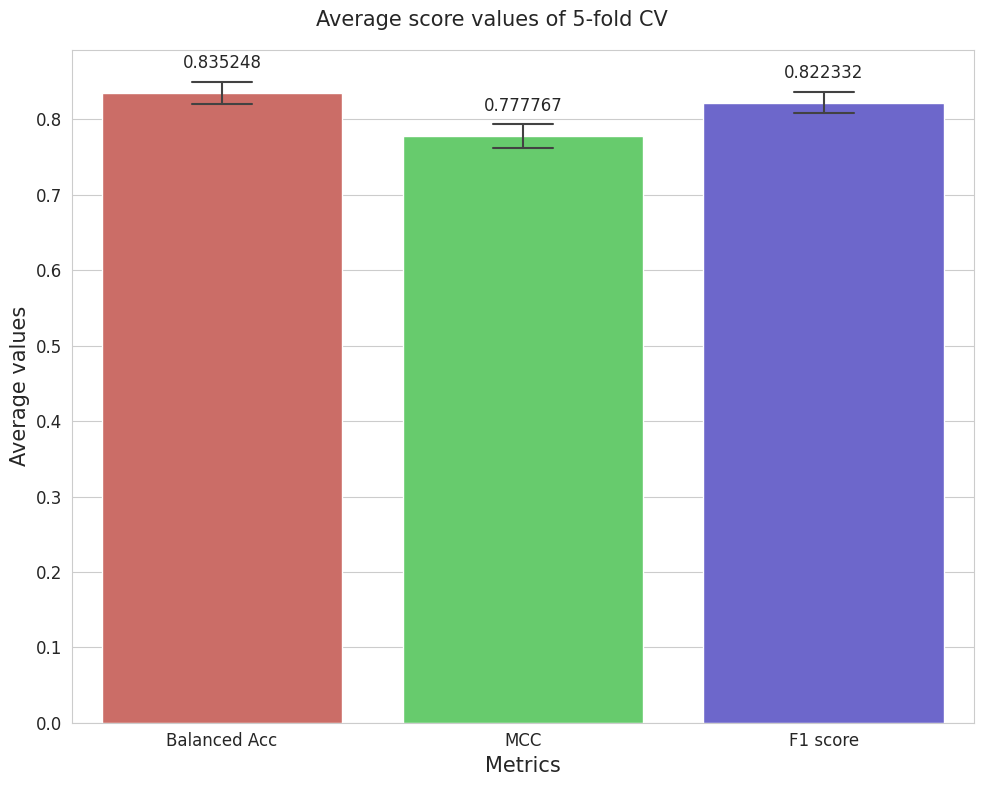

In [39]:
my_dict = {'Balanced Acc': [results_all[i]['valid_bal_acc'][results_all[i]['valid_loss'].index(min(results_all[i]['valid_loss']))] for i in range(len(results_all))], 
           'MCC': [results_all[i]['valid_mcc'][results_all[i]['valid_loss'].index(min(results_all[i]['valid_loss']))] for i in range(len(results_all))], 
           'F1 score': [results_all[i]['valid_f_score'][results_all[i]['valid_loss'].index(min(results_all[i]['valid_loss']))] for i in range(len(results_all))]}

my_df = pd.DataFrame(my_dict)
print(my_df)
plt.rcParams["figure.autolayout"] = True
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')
ax = sns.barplot(data= my_df, estimator=np.mean, color='blue', palette='hls', errorbar="sd", capsize=.2, errwidth=1.5)
ax.bar_label(ax.containers[0], padding=15)

plt.xlabel('Metrics', fontsize=15)
plt.ylabel(f'Average values', fontsize=15)

plt.suptitle(f'Average score values of 5-fold CV', fontsize=15)
plt.savefig(f'/kaggle/working/vit_cv_scores.png')
plt.show()

---

## 5. **Final Model Training**  

Once we've acquired performance estimates through cross-validation, we can move forward with training the model using a conventional training-validation split and the `engine` script described above. Subsequently, we will save the trained model weights to a specified file path, enabling us to load and make predictions on the test set.

In [40]:
def train_vision_transformer(train_dataset, class_weights, device, save_file_name):
    # Define train and validation indices
    train_indices, val_indices = train_test_split(
        list(range(len(train_dataset))),
        test_size=0.15,
        stratify=train_dataset.targets,
        random_state=42
    )
    
    # Create train and validation subsets
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(train_dataset, val_indices)

    # Create train and validation loaders
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    start_time = timer()

    # Load the model and add a fitting final layer
    weights = models.ViT_B_16_Weights.DEFAULT
    vit_model = models.vit_b_16(weights=weights)
    new_heads = nn.Sequential(nn.Linear(in_features=768, out_features=5, bias=True))
    vit_model.heads = new_heads

    #  Here we set the loss function & optimizer
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(vit_model.parameters(), lr=0.0001)
    exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)

    print('Start Training of final model')
    results, final_model = engine.train_with_early_stopping(
        model=vit_model,
        train_dataloader=train_loader,
        valid_dataloader=val_loader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=10,
        device=device
    )

    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds\n")

    MODEL_SAVE_PATH = os.path.join('/kaggle/working/',save_file_name)
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=final_model.state_dict(), f=MODEL_SAVE_PATH)

    helper_functions.plot_loss_curves(results)
    plt.savefig(f'/kaggle/working/{save_file_name}_training_curves.png')

Start Training of final model


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7053 | train_bal_acc: 0.7119 | train_mcc: 0.6300 | valid_loss: 0.5154 | valid_bal_acc: 0.7711 | valid_mcc: 0.6679
Epoch: 2 | train_loss: 0.3815 | train_bal_acc: 0.8512 | train_mcc: 0.8000 | valid_loss: 0.4523 | valid_bal_acc: 0.8328 | valid_mcc: 0.7705
Epoch: 3 | train_loss: 0.2729 | train_bal_acc: 0.8907 | train_mcc: 0.8493 | valid_loss: 0.3407 | valid_bal_acc: 0.8585 | valid_mcc: 0.8072
Epoch: 4 | train_loss: 0.1932 | train_bal_acc: 0.9266 | train_mcc: 0.8994 | valid_loss: 0.3485 | valid_bal_acc: 0.8663 | valid_mcc: 0.8195
Epoch: 5 | train_loss: 0.1443 | train_bal_acc: 0.9502 | train_mcc: 0.9311 | valid_loss: 0.3593 | valid_bal_acc: 0.8619 | valid_mcc: 0.8075
Epoch: 6 | train_loss: 0.1012 | train_bal_acc: 0.9662 | train_mcc: 0.9537 | valid_loss: 0.3449 | valid_bal_acc: 0.8736 | valid_mcc: 0.8184
Epoch: 7 | train_loss: 0.0923 | train_bal_acc: 0.9692 | train_mcc: 0.9576 | valid_loss: 0.4594 | valid_bal_acc: 0.8671 | valid_mcc: 0.8189
Epoch: 8 | train_loss: 0.07

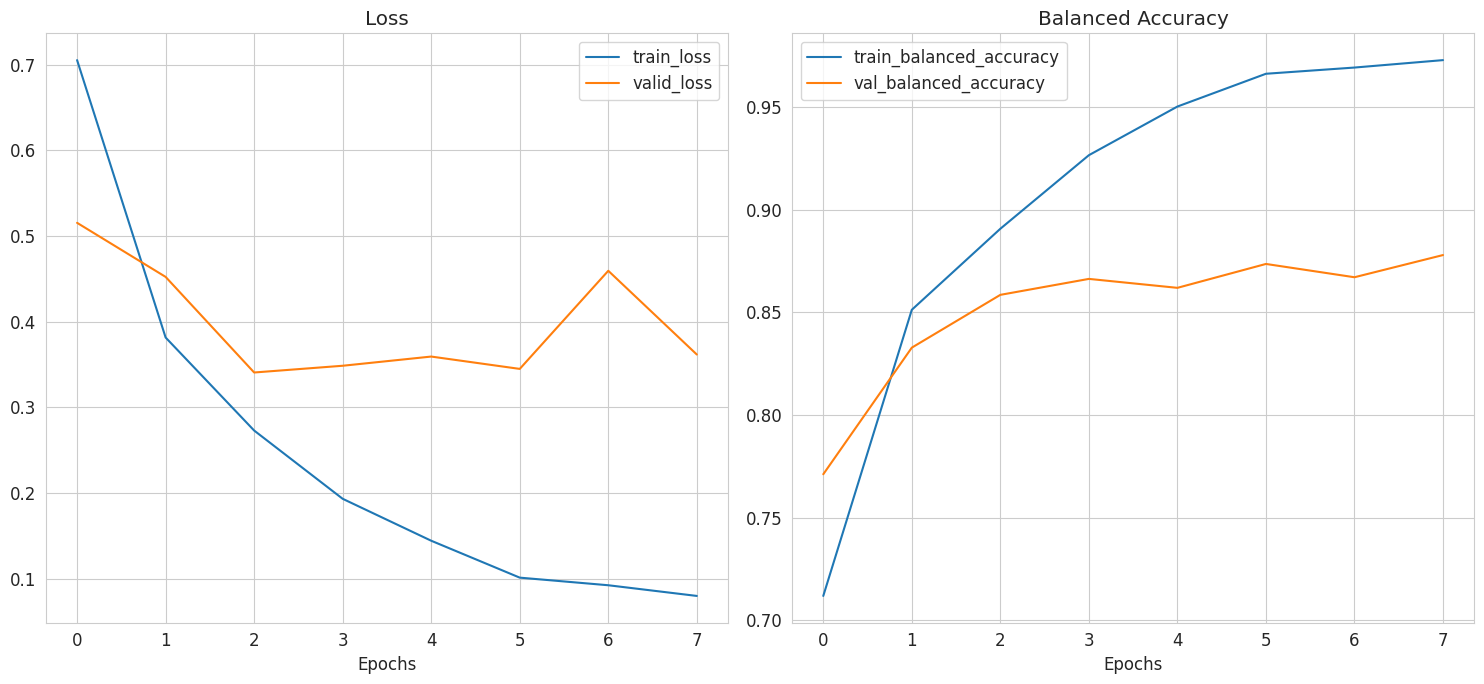

In [41]:
train_vision_transformer(train_dataset=train_dataset, class_weights=class_weights, device=device, save_file_name = "ViT_model.pth")

Having trained the model we evaluate it on the held out test set utilizing the `evaluate_model` function:


In [15]:
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score
# Initialize the model
weights = models.ViT_B_16_Weights.DEFAULT
vit_model = models.vit_b_16(weights=weights)
new_heads = nn.Sequential(nn.Linear(in_features=768, out_features=5, bias=True))
vit_model.heads = new_heads

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Load the saved weights
vit_model.load_state_dict(torch.load("ViT_model.pth"))
vit_model.to(device)

def evaluate_model(model, test_loader, loss_fn, device):
    model.eval()
    with torch.inference_mode():
        all_predictions = []
        all_true_labels = []

        test_loss, test_bal_acc, test_mcc, test_f_score = 0, 0, 0, 0
        for batch, (X, y) in enumerate(test_loader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)
            
            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate scores
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_bal_acc += balanced_accuracy_score(y.cpu().numpy(), test_pred_labels.cpu().numpy())
            test_mcc += matthews_corrcoef(y.cpu().numpy(), test_pred_labels.cpu().numpy())
            test_f_score += f1_score(y.cpu().numpy(), test_pred_labels.cpu().numpy(), average='weighted')

            all_predictions.extend(test_pred_labels.cpu().numpy())
            all_true_labels.extend(y.cpu().numpy())

        # Adjust metrics to get average loss and accuracy per batch
        test_loss = test_loss / len(test_loader)
        test_bal_acc = test_bal_acc / len(test_loader)
        test_mcc = test_mcc / len(test_loader)
        test_f_score = test_f_score / len(test_loader)
        
        print(f'Test loss: {test_loss} | Test bal acc {test_bal_acc} | Test mcc {test_mcc} | Test_f_score {test_f_score}\n')
        
        score_dict = {
            'test_loss': test_loss,
            'test_bal_acc': test_bal_acc,
            'test_mcc': test_mcc,
            'test_f_score': test_f_score,
            'all_predictions': all_predictions,
            'all_true_labels': all_true_labels
        }
        return score_dict

In [16]:
result = evaluate_model(model = vit_model, test_loader = test_loader, loss_fn = loss_fn , device = device)

Test loss: 0.361649711150676 | Test bal acc 0.87790796009546 | Test mcc 0.8158571344496427 | Test_f_score 0.8517180681720948



In [17]:
scores = [result["test_loss"],result["test_bal_acc"],result["test_mcc"]]
metrics = ["Loss","Balanced Accuracy","MCC"]

### 5.1 *Final Model performance on the test set*

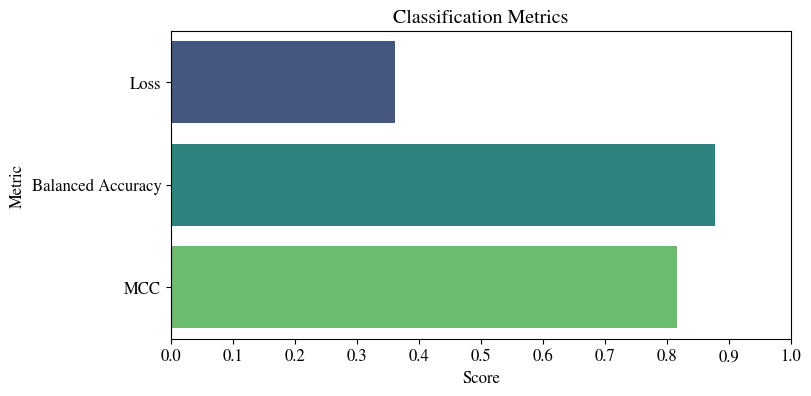

In [25]:
plt.figure(figsize=(8, 4))
sns.barplot(x=scores,y = metrics, palette="viridis")
plt.xticks(np.arange(0.0,1.1,0.1))
plt.xlabel('Score')
plt.ylabel('Metric')
plt.title('Classification Metrics')
plt.savefig("ViT_model_scores.jpg", dpi = 300)
plt.show()

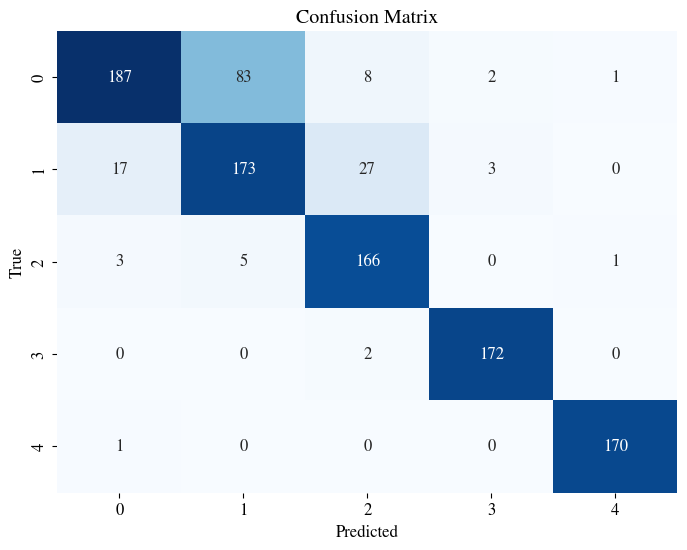

In [26]:
cm = confusion_matrix(result['all_true_labels'], result['all_predictions'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(f'ViT_final_model_cm.jpg', dpi=300)
plt.show()

---

## 6. **Final Model training with Data Augmentation to reduce overfitting**

As observed above the final model is overfitting on the training set. To address this issue we employ data augmentation. By introducing variability into the dataset, data augmentation helps prevent the model from excessively fitting to the specific noise present in the training data.

We utilize:
1. A Horizontal flip either left or right 
2. A random rotation of 10 degrees 
3. A random shift in brigtness, contrast, saturation and hue

In [20]:
# Define train and val transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Start Training of final model


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7111 | train_bal_acc: 0.7086 | train_mcc: 0.6288 | valid_loss: 0.5168 | valid_bal_acc: 0.7955 | valid_mcc: 0.7181
Epoch: 2 | train_loss: 0.4827 | train_bal_acc: 0.7996 | train_mcc: 0.7375 | valid_loss: 0.4124 | valid_bal_acc: 0.8373 | valid_mcc: 0.7679
Epoch: 3 | train_loss: 0.4013 | train_bal_acc: 0.8405 | train_mcc: 0.7800 | valid_loss: 0.4616 | valid_bal_acc: 0.8183 | valid_mcc: 0.7392
Epoch: 4 | train_loss: 0.3402 | train_bal_acc: 0.8610 | train_mcc: 0.8094 | valid_loss: 0.3828 | valid_bal_acc: 0.8428 | valid_mcc: 0.7994
Epoch: 5 | train_loss: 0.3048 | train_bal_acc: 0.8810 | train_mcc: 0.8337 | valid_loss: 0.3755 | valid_bal_acc: 0.8590 | valid_mcc: 0.7865
Epoch: 6 | train_loss: 0.2661 | train_bal_acc: 0.8967 | train_mcc: 0.8550 | valid_loss: 0.3892 | valid_bal_acc: 0.8443 | valid_mcc: 0.7664
Epoch: 7 | train_loss: 0.2419 | train_bal_acc: 0.9030 | train_mcc: 0.8647 | valid_loss: 0.3269 | valid_bal_acc: 0.8648 | valid_mcc: 0.8086
Epoch: 8 | train_loss: 0.19

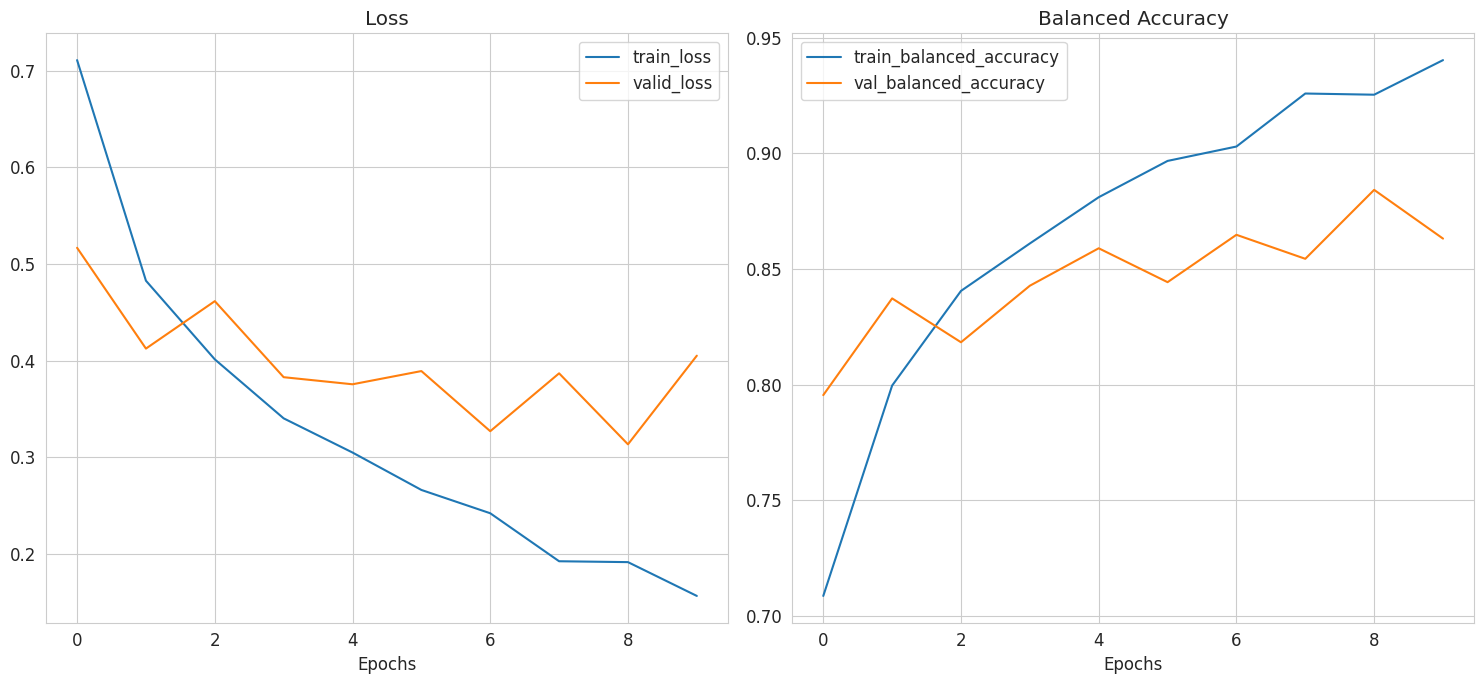

In [48]:
# Reload training data with augmentations
train_indices, val_indices = train_test_split(train_idx, test_size=0.15, stratify=train_targets, random_state=42)

train_dataset = ImageFolder(DATA_DIR, transform=train_transforms)
val_dataset = ImageFolder(DATA_DIR, transform=val_transforms)

train_subset = Subset(train_dataset, train_indices)
train_targets=[train_dataset.targets[i] for i in train_indices]
                                              
val_subset = Subset(val_dataset, val_indices)
val_targets=[train_dataset.targets[i] for i in val_indices]
                                              
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
                                              
                                              
train_vision_transformer(train_dataset=train_dataset, class_weights=class_weights, device=device, save_file_name = "ViT_model_aug.pth")

### 6.1 *Post data augmentation Final Model performance on the test set*

In [27]:
# Load the saved weights
weights = models.ViT_B_16_Weights.DEFAULT
vit_model_aug = models.vit_b_16(weights=weights)
new_heads = nn.Sequential(nn.Linear(in_features=768, out_features=5, bias=True))
vit_model_aug.heads = new_heads
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
vit_model_aug.load_state_dict(torch.load("ViT_model_aug.pth"))
vit_model_aug.to(device)

# Evaluate on the test set
result = evaluate_model(model = vit_model_aug, test_loader = test_loader, loss_fn = loss_fn , device = device)

Test loss: 0.36209896113723516 | Test bal acc 0.8790888104950603 | Test mcc 0.8136379720352807 | Test_f_score 0.849832748255902



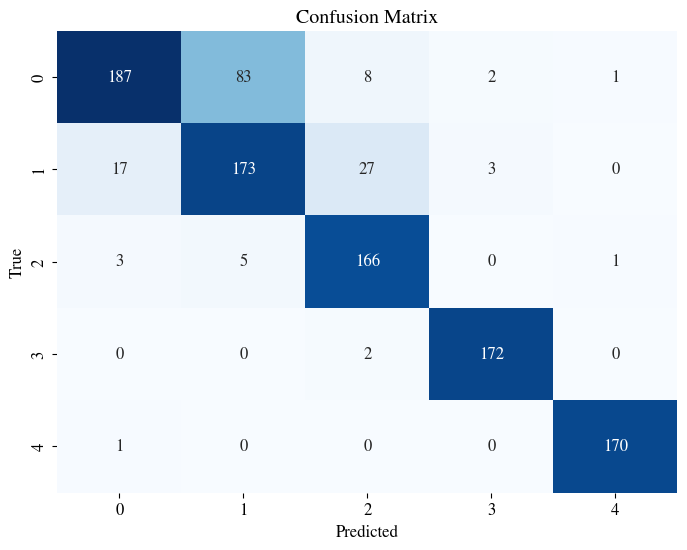

In [28]:
cm = confusion_matrix(result['all_true_labels'], result['all_predictions'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(f'/kaggle/working/ViT_final_model_aug_cm.png', dpi=300)
plt.show()

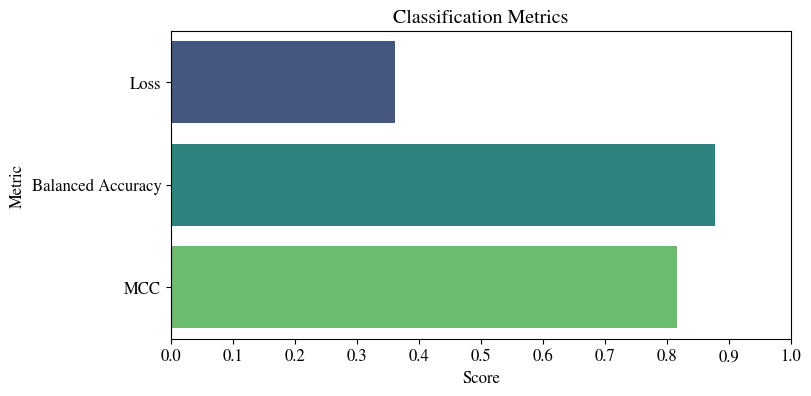

In [29]:
plt.figure(figsize=(8, 4))
sns.barplot(x=scores,y = metrics, palette="viridis")
plt.xticks(np.arange(0.0,1.1,0.1))
plt.xlabel('Score')
plt.ylabel('Metric')
plt.title('Classification Metrics')
plt.savefig(f'ViT_final_aug_model_cm.jpg', dpi=300)
plt.show()

8. Visualizing 

--- 

## 7. **Visualizing the forward pass of the Vision Transformer & Attention**

In order to have a better intuition on how the Vision Transformer Base 16 model function, we can attempt to visualize the intermediate outputs of the main layers as an image is passed into the forward pass loop of the trained model on the augmented dataset which produced the best results. 

In [33]:
def image_pass(model, image, y_true):
    image_batch = image.unsqueeze(0).to(device)
    model.to(device)
    model.eval()

    # Define a list to store the hook's output
    att_hook_output = []
    conv_hook_output = []
    
    # Define the hook callback function
    def conv_layer_hook(module,input, output):
        conv_hook_output.append(output[0])
    
    conv_layers_count = 0
    for name, module in vit_model_aug.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_hook = module.register_forward_hook(conv_layer_hook)
            conv_layers_count += 1
    print(f"There are a total of {conv_layers_count} Convolutional layers\n")
    
    def multi_head_attention_hook(module, input, output):
        att_hook_output.append(output[0])

    # Register the hook on the specific layer
    attention_layers_count = 0
    for name, module in vit_model_aug.named_modules():
        if isinstance(module, nn.MultiheadAttention):
            att_hook = module.register_forward_hook(multi_head_attention_hook)
            attention_layers_count += 1
    print(f"There are a total of {attention_layers_count} Multi head attention layers\n")
    
    # Perform the forward pass
    output = model(image_batch)
    print("All forward pass hooks registered \n")
    
    return output, att_hook_output, conv_hook_output

In [34]:
def visualize_process(image,conv_hook_results,att_hook_results,y_true,output,img_id):
    # 1. Plot the input image
    print("---------- 1. The original input image is: ----------\n")
    plt.figure()
    image = image.squeeze().cpu().detach().numpy()
    image = image.transpose((1, 2, 0))
    plt.title(f"Input Image, true class: {y_true}")
    plt.imshow(image)
    plt.axis("off")
    plt.savefig(f"input_img_{id}.jpg",dpi = 300)
    plt.show()
    
    # 2. Plot the patches produced from the Convolutional layer
    conv_results = conv_hook_results[0].squeeze().cpu().detach().numpy()
    print("---------- 2. Example image patches from the convolutional layer: ----------\n")
    fig, axes = plt.subplots( 4, 5, figsize=(12, 10))
    plt.suptitle("Image patches")
    for i, ax in enumerate(axes.ravel()):
        if i < 20:
            ax.imshow(conv_results[i,:,:], cmap = "gray")
            ax.set_title(f"Patch {i + 1} out of 768")
            ax.axis('off')  # Hide axis labels
    plt.tight_layout()
    plt.savefig(f"cnn_patch_img_{id}.jpg",dpi = 300)
    plt.show()
    
    # Flattened patch
    print("---------- 3. Flattened image patches from the convolutional layer: ----------\n")
    fig, axes = plt.subplots(4, 5, figsize=(12, 10))
    plt.suptitle("Flattened Image patches:")
    for i, ax in enumerate(axes.ravel()):
        if i < 20:
            ax.hist(conv_results[i,:,:].flatten(),bins=50)
            ax.set_title(f"Patch {i + 1} out of 768")
            ax.set_xlabel('Counts')
            ax.set_ylabel('Values')
    plt.tight_layout()
    plt.savefig(f"cnn_flatpatch_img_{id}.jpg",dpi = 300)
    plt.show()
    
    # 3. Plot the attention weights between the pixels of the patches
    print("----------  4. Attention layer output for all 768 image patches and each of their 196 pixels: ------------\n")
    fig,axes = plt.subplots(3,4, figsize=(22, 20))
    plt.suptitle("Image Patch to Image patch, Attention output visualization: 768 image patches of embedding shape 1 by 196")
    for i, ax in enumerate(axes.ravel()):
        att_results = att_hook_results[i].squeeze().cpu().detach().numpy()
        if i < 20:
            sns.heatmap(att_results.T, cmap="gray", ax=ax, robust = True)
            ax.set_xlabel('Vector Embedding Index')
            ax.set_ylabel('Image Patch Index')
            ax.set_title(f"Weights for attention layer {i + 1} out of 12")
    plt.tight_layout()
    plt.savefig(f"att_img_{id}.jpg",dpi = 300)
    plt.show()
    
    # 4. Plot pred proababilites of the models outcome
    print("---------- 5. Output of Softmax on the model predicted logits ------------\n")
    output = output[0].cpu().detach().numpy()
    # Use softmax 
    exp_x = np.exp(output)
    sum_exp_x = np.sum(exp_x, axis=0)
    softmax_probs = exp_x / sum_exp_x
    plt.figure()
    plt.title(f"Model prediction: {np.argmax(softmax_probs)} | True class: {y_true}")
    sns.barplot(x = ["Class 0","Class 1","Class 2","Class 3", "Class 4"], y = softmax_probs)
    plt.savefig(f"pred_img_{id}.jpg",dpi = 300)
    plt.show()

There are a total of 1 Convolutional layers

There are a total of 12 Multi head attention layers

All forward pass hooks registered 

---------- 1. The original input image is: ----------



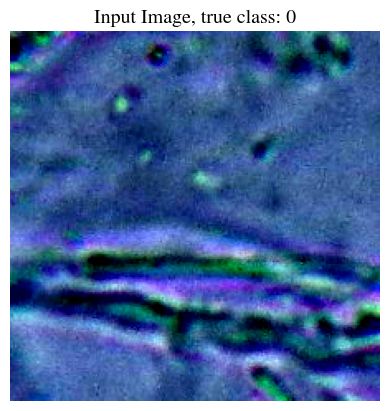

---------- 2. Example image patches from the convolutional layer: ----------



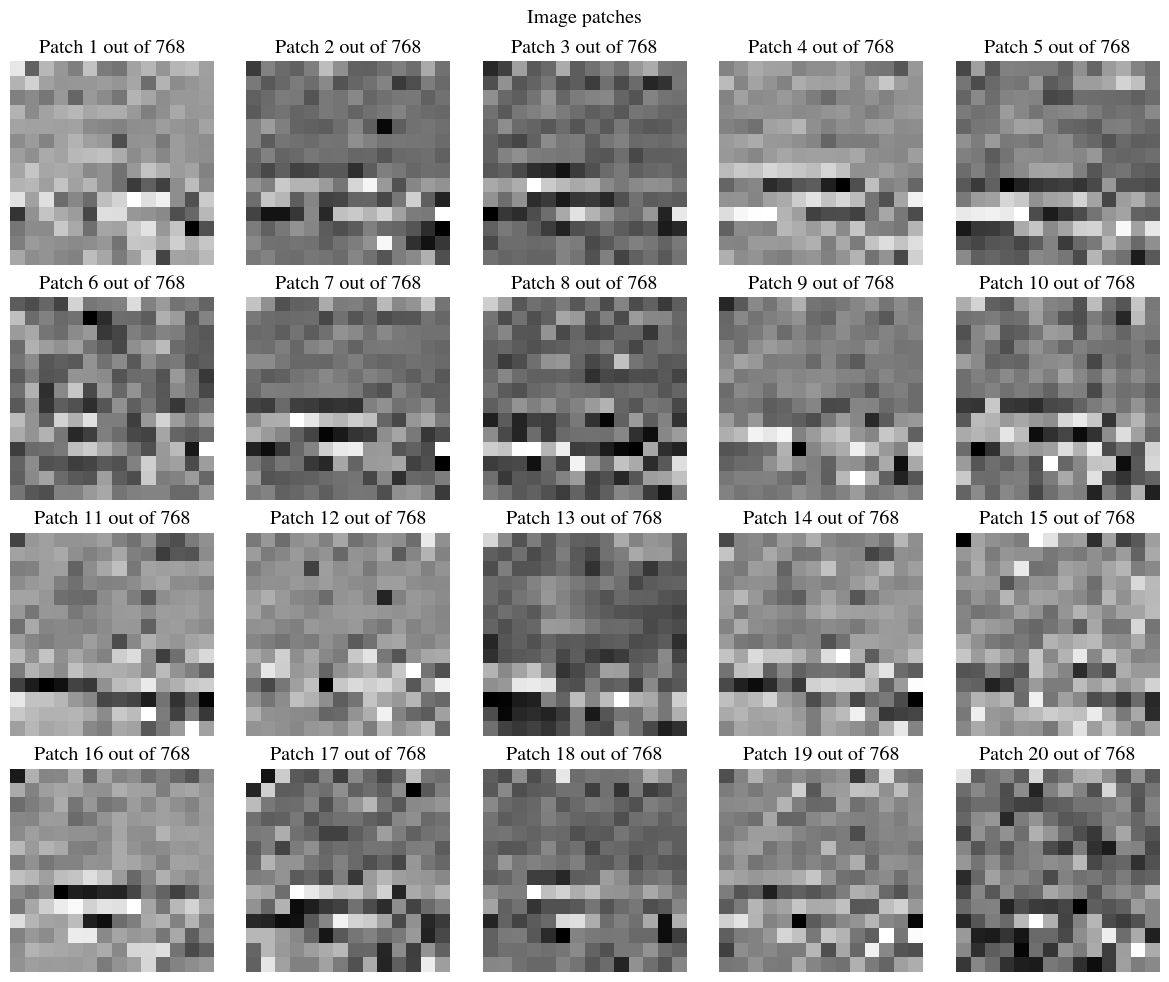

---------- 3. Flattened image patches from the convolutional layer: ----------



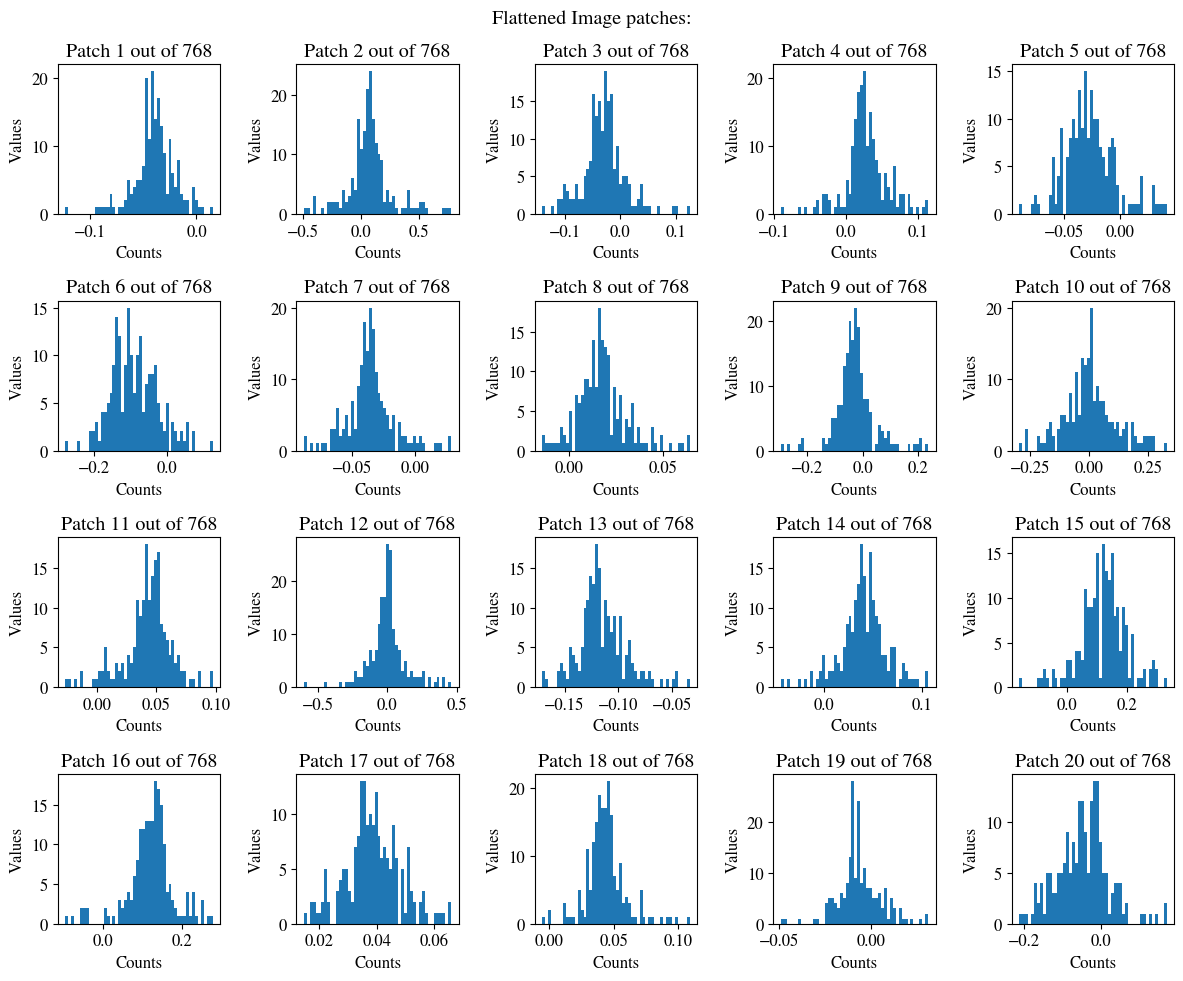

----------  4. Attention layer output for all 768 image patches and each of their 196 pixels: ------------



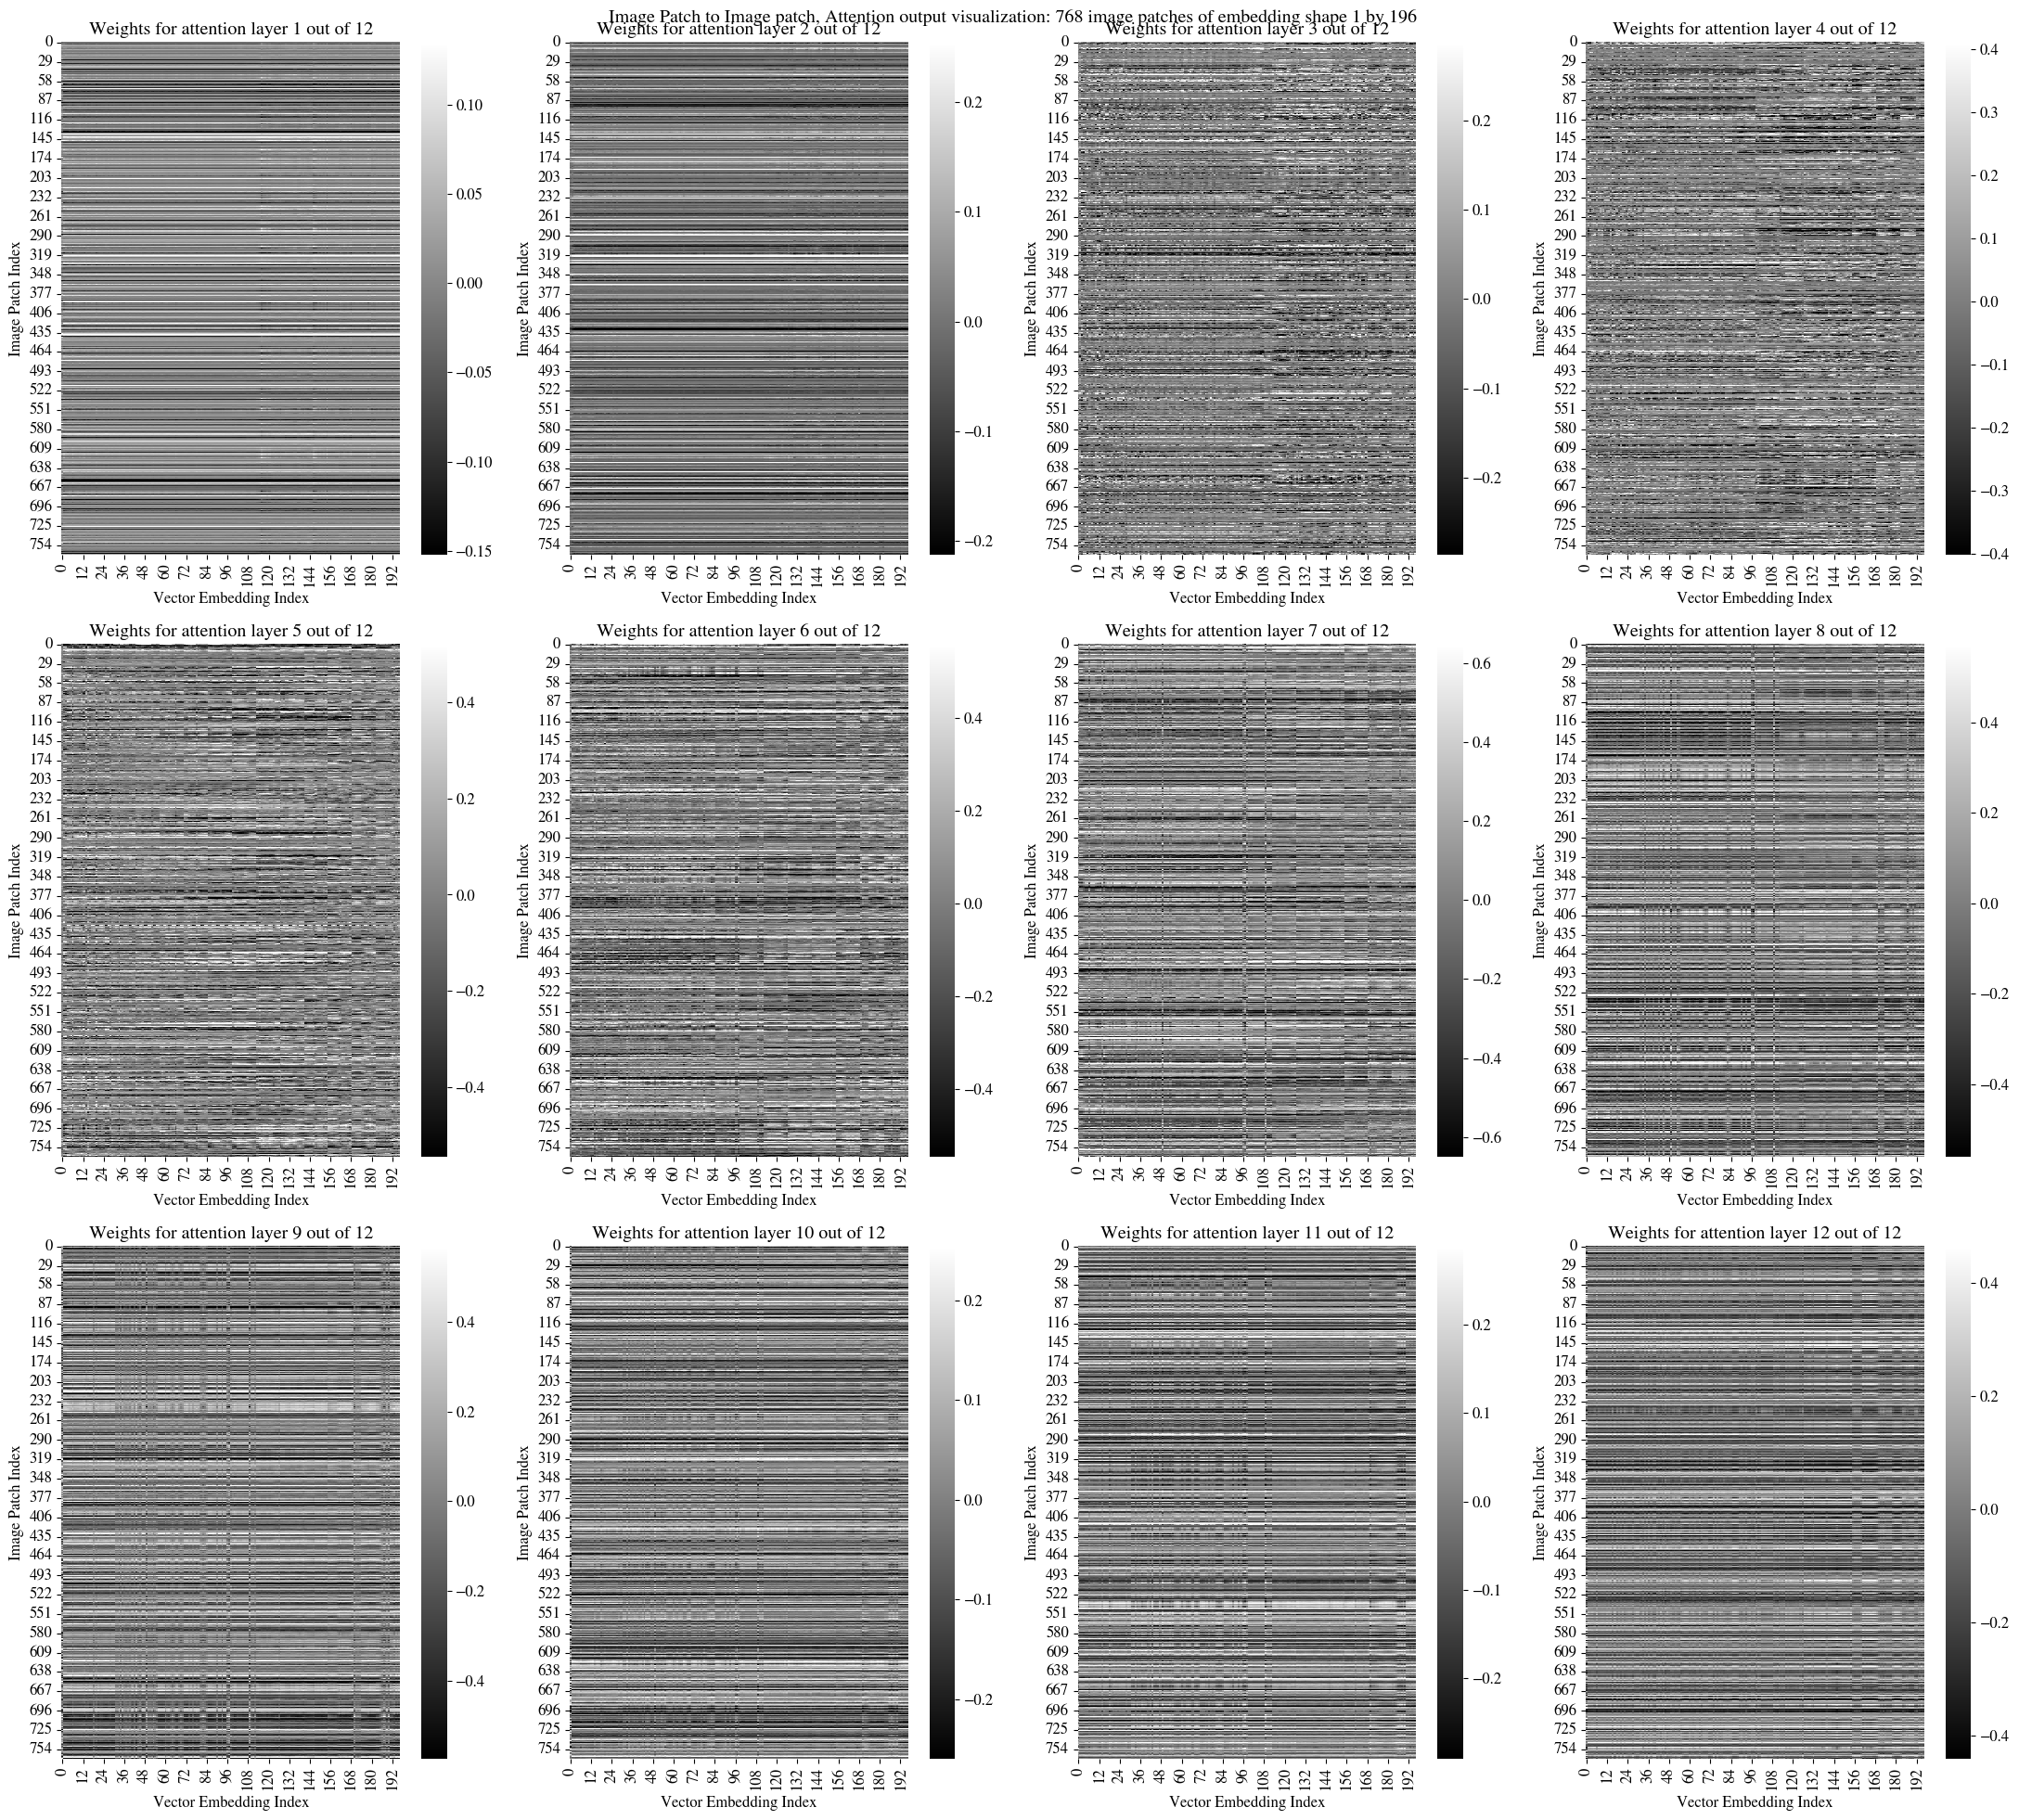

---------- 5. Output of Softmax on the model predicted logits ------------



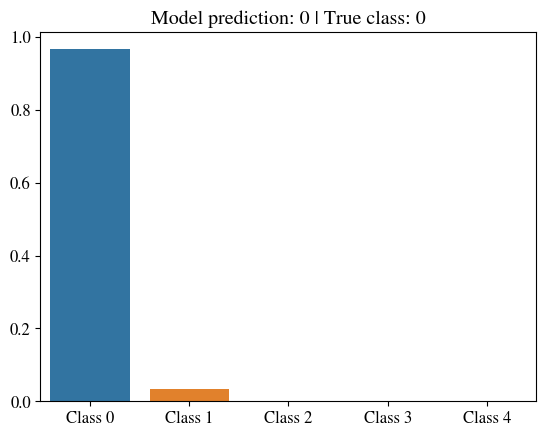

In [35]:
img_id = 600
model = vit_model_aug
image = test_dataset[img_id][0]
y_true =  test_dataset[img_id][1]

output, att_hook_output, conv_hook_output = image_pass(model, image, y_true)
visualize_process(image,conv_hook_output, att_hook_output, y_true, output, img_id)